# COVID-19 Growth Analysis
> Visualizations of the growth of COVID-19.

- comments: true
- author: Thomas Wiecki
- categories: [growth]
- image: images/covid-growth.png
- permalink: /growth-analysis/

In [1]:
#hide
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import requests
import io

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

In [2]:
#hide
def load_timeseries(name, 
                    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'):
    # Thanks to kasparthommen for the suggestion to directly download
    url = f'{base_url}/time_series_19-covid-{name}.csv'
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'
    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, 
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     .rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])
    return df

df_confirmed = load_timeseries('Confirmed')

# Estimated critical cases
p_crit = .05
df_confirmed = df_confirmed.assign(cases_crit=df_confirmed.cases*p_crit)

# Compute days relative to when 100 confirmed cases was crossed
df_confirmed.loc[:, 'days_since_100'] = np.nan
for country in df_confirmed.country.unique():
    df_confirmed.loc[(df_confirmed.country == country), 'days_since_100'] = \
        np.arange(-len(df_confirmed.loc[(df_confirmed.country == country) & (df_confirmed.cases < 100)]), 
                  len(df_confirmed.loc[(df_confirmed.country == country) & (df_confirmed.cases >= 100)]))
    
annotate_kwargs = dict(
    s='Based on COVID Data Repository by Johns Hopkins CSSE ({})\nBy Thomas Wiecki'.format(df_confirmed.index.max().strftime('%B %d, %Y')), 
    xy=(0.05, 0.01), xycoords='figure fraction', fontsize=10)

In [3]:
#hide
# Country names seem to change quite a bit
df_confirmed.country.unique()

array(['Thailand', 'Japan', 'Singapore', 'Nepal', 'Malaysia', 'Canada',
       'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland',
       'United Arab Emirates', 'Philippines', 'India', 'Italy', 'Sweden',
       'Spain', 'Belgium', 'Egypt', 'Lebanon', 'Iraq', 'Oman',
       'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia',
       'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil',
       'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania',
       'Estonia', 'San Marino', 'Belarus', 'Iceland', 'Lithuania',
       'Mexico', 'New Zealand', 'Nigeria', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Armenia',
       'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia',
       'Morocco', 'Saudi Arabia', 'Senegal', 'Argentina', 'Chile',
       'Jordan', 'Ukraine', 'Hungary', 'Liechtenstein', 'Poland',
       'Tunisia', 'Bosnia and Herzegovina', 'Slovenia', 'South Africa',
       'Bhutan', 'Cameroon', 'Colombia', 'Costa R

In [4]:
#hide
european_countries = ['Italy', 'Germany', 'France (total)', 'Spain', 'United Kingdom (total)', 
                      'Iran']
large_engl_countries = ['US (total)', 'Canada (total)', 'Australia (total)']
asian_countries = ['Singapore', 'Japan', 'Korea, South', 'Hong Kong']
south_american_countries = ['Argentina', 'Brazil', 'Colombia', 'Chile']

country_groups = [european_countries, large_engl_countries, asian_countries, south_american_countries]
line_styles = ['-', ':', '--', '-.']

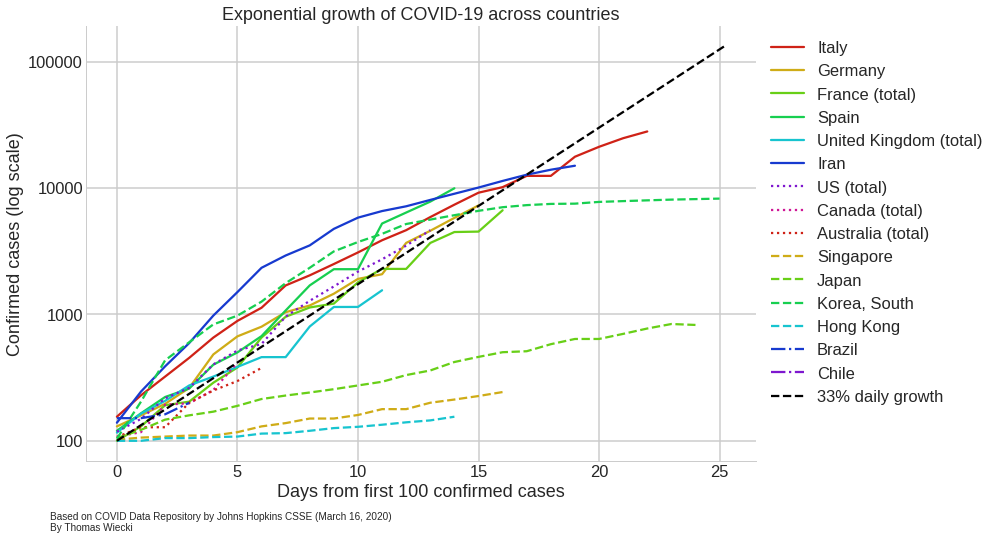

In [5]:
#collapse-hide

def plot_countries(df, countries, min_cases=100, ls='-', col='cases'):
    for country in countries:
        df_country = df.loc[(df.country == country) & (df.cases >= min_cases)]
        if len(df_country) == 0:
            continue
        df_country.reset_index()[col].plot(label=country, ls=ls)
        
sns.set_palette(sns.hls_palette(8, l=.45, s=.8)) # 8 countries max
fig, ax = plt.subplots(figsize=(12, 8))

for countries, ls in zip(country_groups, line_styles):
    plot_countries(df_confirmed, countries, ls=ls)

x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, 100 * (1.33) ** x, ls='--', color='k', label='33% daily growth')

ax.set(yscale='log',
       title='Exponential growth of COVID-19 across countries',
       xlabel='Days from first 100 confirmed cases',
       ylabel='Confirmed cases (log scale)')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.annotate(**annotate_kwargs)
sns.despine();

In [6]:
#hide
# This creates a preview image for the blog post and home page
fig.savefig('../images/covid-growth.png')

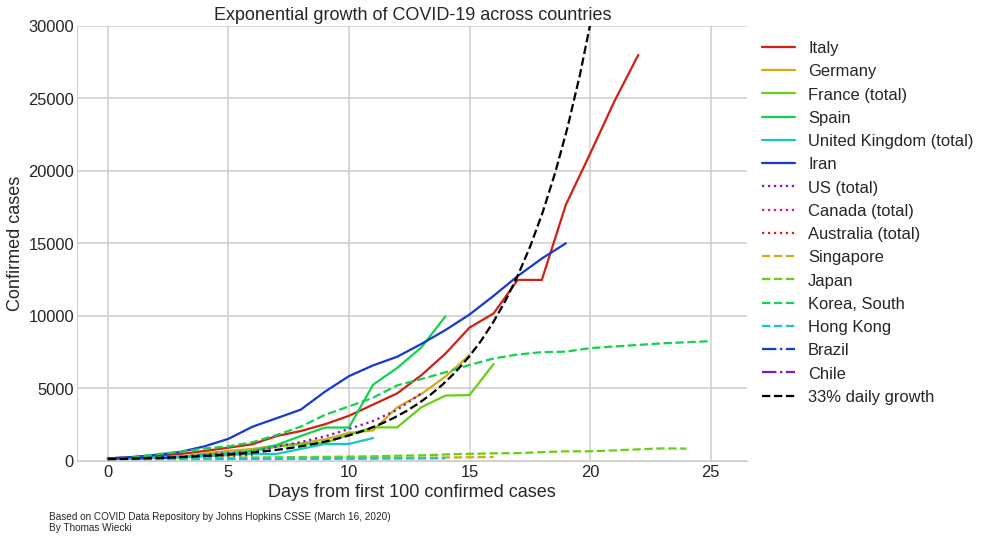

In [7]:
#collapse-hide
fig, ax = plt.subplots(figsize=(12, 8))

for countries, ls in zip(country_groups, line_styles):
    plot_countries(df_confirmed, countries, ls=ls)

x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, 100 * (1.33) ** x, ls='--', color='k', label='33% daily growth')

ax.set(title='Exponential growth of COVID-19 across countries',
       xlabel='Days from first 100 confirmed cases',
       ylabel='Confirmed cases', ylim=(0, 30000))
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.annotate(**annotate_kwargs)
sns.despine();

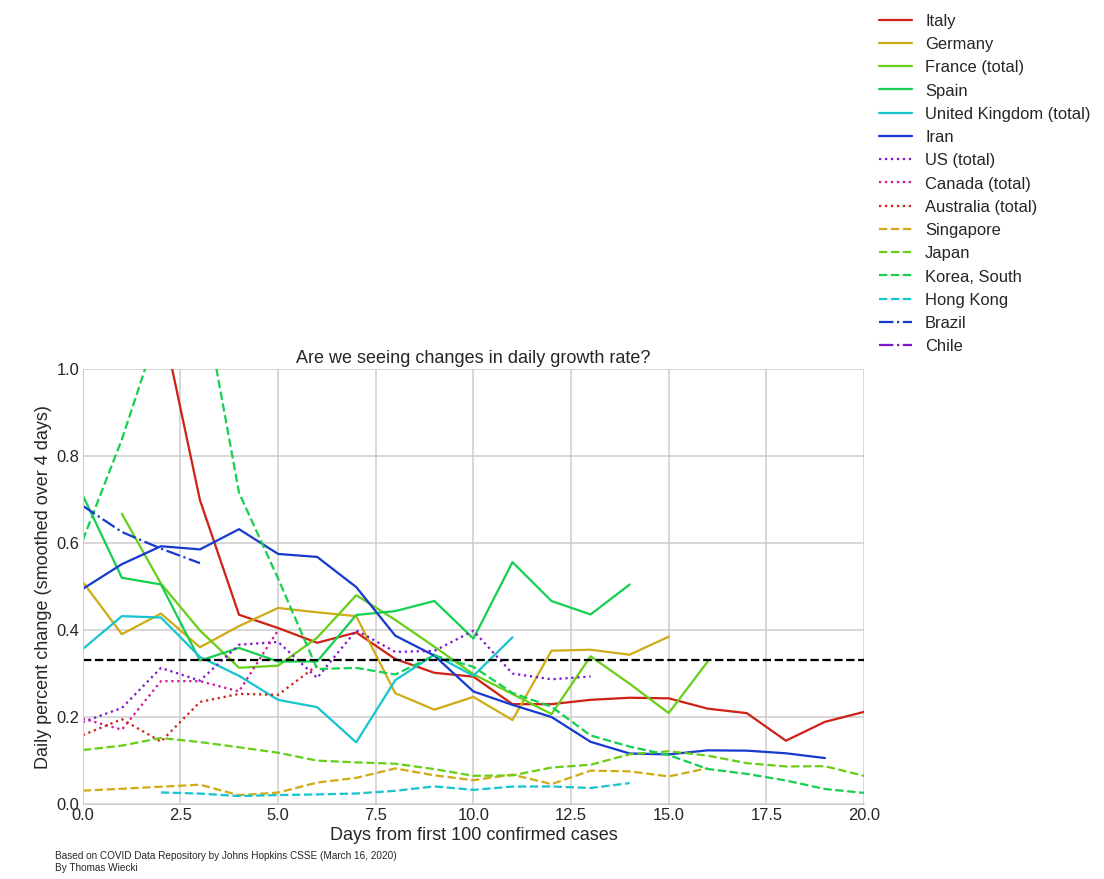

In [8]:
#collapse-hide
smooth_days = 4
fig, ax = plt.subplots(figsize=(14, 8))
df_confirmed['pct_change'] = (df_confirmed
                              .groupby('country')
                              .cases
                              .pct_change()
                              .rolling(smooth_days)
                              .mean()
)

for countries, ls in zip(country_groups, line_styles):
    (df_confirmed.set_index('country')
                 .loc[countries]
                 .loc[lambda x: x.cases > 100]
                 .reset_index()
                 .set_index('days_since_100')
                 .groupby('country', sort=False)['pct_change']
                 .plot(ls=ls)
    )

ax.set(ylim=(0, 1),
       xlim=(0, 20),
       title='Are we seeing changes in daily growth rate?',
       xlabel='Days from first 100 confirmed cases',
       ylabel='Daily percent change (smoothed over {} days)'.format(smooth_days),
)
ax.axhline(.33, ls='--', color='k')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(bbox_to_anchor=(1.0, 1.0))
sns.despine()
ax.annotate(**annotate_kwargs);

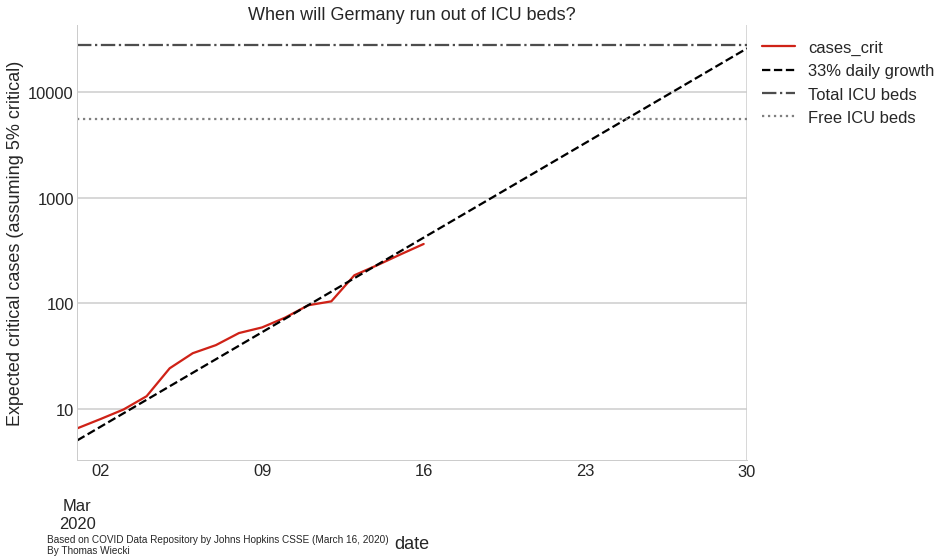

In [9]:
#collapse-hide
sns.set_palette(sns.hls_palette(8, l=.45, s=.8)) # 8 countries max
fig, ax = plt.subplots(figsize=(12, 8))

# 28000 ICU beds total, 80% occupied
icu_germany = 28000
icu_germany_free = .2

df_tmp = df_confirmed.loc[lambda x: (x.country == 'Germany') & (x.cases > 100)].cases_crit
df_tmp.plot(ax=ax)

x = np.linspace(0, 30, 30)
pd.Series(index=pd.date_range(df_tmp.index[0], periods=30),
          data=100*p_crit * (1.33) ** x).plot(ax=ax,ls='--', color='k', label='33% daily growth')

ax.axhline(icu_germany, color='.3', ls='-.', label='Total ICU beds')
ax.axhline(icu_germany * icu_germany_free, color='.5', ls=':', label='Free ICU beds')
ax.set(yscale='log',
       title='When will Germany run out of ICU beds?',
       ylabel='Expected critical cases (assuming {:.0f}% critical)'.format(100 * p_crit),
)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(bbox_to_anchor=(1.0, 1.0))
sns.despine()
ax.annotate(**annotate_kwargs);

Updated daily by [GitHub Actions](https://github.com/features/actions).

This visualization was made by [Thomas Wiecki](https://twitter.com/twiecki)[^1].

[^1]:  Data sourced from ["2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/) [GitHub repository](https://github.com/CSSEGISandData/COVID-19) and recreates the (pay-walled) plot in the [Financial Times]( https://www.ft.com/content/a26fbf7e-48f8-11ea-aeb3-955839e06441). This code is provided under the [BSD-3 License](https://github.com/twiecki/covid19/blob/master/LICENSE). Link to [original notebook](https://github.com/twiecki/covid19/blob/master/covid19_growth.ipynb).